In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from PIL import Image
import networkx as nx
import numpy as np
# from skimage import measure
from streetview_graph import StreetView_Graph
from glob import glob
from tqdm import tqdm

## 高频词

In [73]:
df = pd.read_csv(r"D:\weibo_result\filtered_final.csv")

C:\Users\Alber\AppData\Local\Temp\ipykernel_33840\3299885018.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\weibo_result\filtered_final.csv")


In [74]:
import re
filtered_df = df.copy()

filtered_df['微博正文_clear'] = df['微博正文'].apply(lambda x: re.sub(r'#.*?#', '', x) if isinstance(x, str) else x)
filtered_df = filtered_df[filtered_df['微博正文_clear'].notna()].reset_index(drop=True)
# filtered_df['微博正文_clear'] = filtered_df['微博正文_clear'].str.replace('#', '', regex=False)

In [75]:
filtered_df['微博正文_clear2'] = filtered_df['微博正文_clear']

In [76]:
for i, row in tqdm(filtered_df[filtered_df['艾特用户'].notna()].iterrows()):
    # Extract the user IDs from the '艾特用户' column
    at_list = row['艾特用户'].split(',')
    at_list_str = [f'@{user}' for user in at_list]
    for at in at_list_str:
        filtered_df.loc[i, '微博正文_clear2'] = row['微博正文_clear'].replace(at, '')

# for i, row in tqdm(filtered_df.iterrows()):
#     if pd.notna(row['艾特用户']):
#         # Extract the user ID from the string
#         at_list = row['艾特用户'].split(',')
#         at_list_str = [f'@{j}' for j in at_list]
#         for at in at_list_str:
#             filtered_df.loc[i, '微博正文_clear2'] = row['微博正文_clear'].replace(at, '')
#     else:
#         filtered_df.loc[i, '微博正文_clear2'] = row['微博正文_clear']
#     #     print(f"Row {i}: {row['微博正文_clear2']}")
#     # if i == 20:
#     #     break

3668it [00:00, 12311.73it/s]


In [79]:
# 确保 '时间' 列是 datetime 格式
filtered_df['发布时间'] = pd.to_datetime(filtered_df['发布时间'], errors='coerce')

# 定义时间段
bins = [
    pd.Timestamp('2021-01-01'),
    pd.Timestamp('2021-05-30'),
    pd.Timestamp('2021-12-31'),
    pd.Timestamp('2023-01-01'),
    pd.Timestamp('2025-01-01')
]
labels = ['2021.1.1-5.30', '2021.5.31-12.31', '2022.1.1-2023.1.1', '2023.1.1-2025.1.1']

# 添加时间段列
filtered_df['时间段'] = pd.cut(filtered_df['发布时间'], bins=bins, labels=labels, right=True)

# filtered_df

In [80]:
from jieba.analyse import extract_tags
import jieba

# 提取关键词
filtered_df['关键词'] = filtered_df['微博正文_clear2'].apply(lambda x: extract_tags(x, topK=20) if isinstance(x, str) else [])

# 分词方法
filtered_df['分词'] = filtered_df['微博正文_clear2'].apply(lambda x: list(jieba.cut(x, use_paddle=True)) if isinstance(x, str) else [])


# # 如果用提取关键词的话，下面的分词就不需要了
# # encoding=utf-8
# import jieba

# # jieba.enable_paddle()# 启动paddle模式。 0.40版之后开始支持，早期版本不支持
# cut_str_list = []
# strs=list(filtered_df['微博正文_clear'])
# for str in tqdm(strs):
#     seg_list = jieba.cut(str,use_paddle=True) # 使用paddle模式
#     cut_str_list.append(list(seg_list))

    # print("Paddle Mode: " + '/'.join(list(seg_list)))


In [81]:
filtered_df.to_csv(r"D:\weibo_result\计算结果\分段结果\filtered_20250515.csv", index=False, encoding='utf-8-sig')

In [54]:
labels

['2021.1.1-5.30', '2021.5.31-12.31', '2022.1.1-2023.1.1', '2023.1.1-2025.1.1']

In [ ]:
word_freq = pd.read_excel(r"C:\Users\Alber\OneDrive - HKUST Connect\Academic\research\graph-restoration\data\0527清洗后数据.xlsx")


In [25]:
selected_word_freq = word_freq[word_freq['时间段'] == '2021.1.1-5.30'].reset_index(drop=True)
keyword_list_1 = [selected_word_freq.loc[i,'关键词'][2:-2].split("', '") for i in range(len(selected_word_freq))]

In [35]:
from collections import Counter

def cal_word_freq(word_freq, time, use_type='分词'):
    if time == 'all':
        selected_word_freq = word_freq.reset_index(drop=True)
    else:
        selected_word_freq = word_freq[word_freq['时间段'] == time].reset_index(drop=True)
    keyword_list = [selected_word_freq.loc[i,use_type][2:-2].split("', '") for i in range(len(selected_word_freq))]
    all_keywords = [word for sublist in keyword_list for word in sublist]

    # 统计词频
    keyword_freq = Counter(all_keywords)

    # 转为DataFrame方便查看
    keyword_freq_df = pd.DataFrame(keyword_freq.items(), columns=['word', 'count']).sort_values(by='count', ascending=False).reset_index(drop=True)
    return keyword_freq_df
    
# 分词
for time in ['2021.1.1-5.30', '2021.5.31-12.31', '2022.1.1-2023.1.1', '2023.1.1-2025.1.1','all']:
    for use_type in ['分词', '关键词']:
        keyword_freq_df = cal_word_freq(word_freq, time, use_type)
        keyword_freq_df.to_csv(f"D:\\weibo_result\\计算结果\\词频\\词频_{time}_{use_type}.csv", index=False, encoding='utf-8-sig')
        print(f"Processed {time} with {use_type}, saved to CSV.")


Processed 2021.1.1-5.30 with 分词, saved to CSV.
Processed 2021.1.1-5.30 with 关键词, saved to CSV.
Processed 2021.5.31-12.31 with 分词, saved to CSV.
Processed 2021.5.31-12.31 with 关键词, saved to CSV.
Processed 2022.1.1-2023.1.1 with 分词, saved to CSV.
Processed 2022.1.1-2023.1.1 with 关键词, saved to CSV.
Processed 2023.1.1-2025.1.1 with 分词, saved to CSV.
Processed 2023.1.1-2025.1.1 with 关键词, saved to CSV.
Processed all with 分词, saved to CSV.
Processed all with 关键词, saved to CSV.


In [32]:
keyword_freq_df

,word,count
0,孩子,731
1,视频,378
2,微博,326
3,生育,154
4,父母,134
...,...,...
9460,遭逢,1
9461,落花,1
9462,蜘蛛网,1
9463,册子,1


In [ ]:
from collections import Counter
import jieba.posseg as pseg
def cal_word_freq(filtered_df, pos_list, use_type='分词'):
    # # 展示带有关键词的前几行数据
# filtered_df[['微博正文_clear2', '关键词']].head()
    if use_type == '分词':
        cut_str_list = filtered_df['分词'].tolist()
    else:
        cut_str_list = filtered_df['关键词'].tolist()
    cut_str_list_all = []
    cut_str_list_all = [item for sublist in cut_str_list if isinstance(sublist, list) for item in sublist]
    word_freq = Counter(cut_str_list_all)
    words = word_freq.keys()
    word_freq_df = pd.DataFrame([word_freq]).T.reset_index().rename(columns={'index': 'word', 0: 'count'})
    # Perform part-of-speech tagging for each word in 'words'
    word_pos = {word: pseg.lcut(word)[0].flag for word in tqdm(words)}
    word_pos_df = pd.DataFrame([word_pos]).T
    word_pos_df.reset_index(inplace=True)
    word_pos_df.rename(columns={'index': 'word', 0: 'pos'}, inplace=True)
    word_freq_merge = word_freq_df.merge(word_pos_df, on='word', how='left')
    filter_word_freq = word_freq_merge[word_freq_merge['pos'].isin(pos_list)].sort_values(by='count', ascending=False)
    return filter_word_freq

keyword_list_1

In [82]:
from collections import Counter
import jieba.posseg as pseg

def cal_word_freq(filtered_df, pos_list, use_type='分词'):
    # # 展示带有关键词的前几行数据
# filtered_df[['微博正文_clear2', '关键词']].head()
    if use_type == '分词':
        cut_str_list = filtered_df['分词'].tolist()
    else:
        cut_str_list = filtered_df['关键词'].tolist()
    cut_str_list_all = []
    cut_str_list_all = [item for sublist in cut_str_list if isinstance(sublist, list) for item in sublist]
    word_freq = Counter(cut_str_list_all)
    words = word_freq.keys()
    word_freq_df = pd.DataFrame([word_freq]).T.reset_index().rename(columns={'index': 'word', 0: 'count'})
    # Perform part-of-speech tagging for each word in 'words'
    word_pos = {word: pseg.lcut(word)[0].flag for word in tqdm(words)}
    word_pos_df = pd.DataFrame([word_pos]).T
    word_pos_df.reset_index(inplace=True)
    word_pos_df.rename(columns={'index': 'word', 0: 'pos'}, inplace=True)
    word_freq_merge = word_freq_df.merge(word_pos_df, on='word', how='left')
    filter_word_freq = word_freq_merge[word_freq_merge['pos'].isin(pos_list)].sort_values(by='count', ascending=False)
    return filter_word_freq


remove_list = pd.read_csv(r"D:\weibo_result\计算结果\remove_list.csv")
pos_list = ['n','v','nr','m','l','i','a','ns','nz','vn','t','b','z','nrt','nt','g','s','vg','tg','ad']

label_index = 3
use_type = '分词'
for label_index in range(len(labels)):
    for use_type in ['分词', '关键词']:
        filter_word_freq = cal_word_freq(filtered_df[filtered_df['时间段'] == labels[label_index]], pos_list, use_type=use_type)


        # filter_word_freq[filter_word_freq['word'].isin(list(remove_list['word']))].sort_values(by='count', ascending=False).to_csv(r"D:\weibo_result\remove_list.csv",index=False,encoding='utf-8-sig')

        final_freq = filter_word_freq[~filter_word_freq['word'].isin(list(remove_list['word']))].sort_values(by='count', ascending=False)
        # final_freq.to_csv(r"D:\weibo_result\word_freq.csv", index=False, encoding='utf-8-sig')
        final_freq.to_csv(rf"D:\weibo_result\计算结果\分段结果\{use_type}_freq_{labels[label_index]}.csv", index=False, encoding='utf-8-sig')

100%|██████████| 37552/37552 [00:05<00:00, 6342.81it/s]


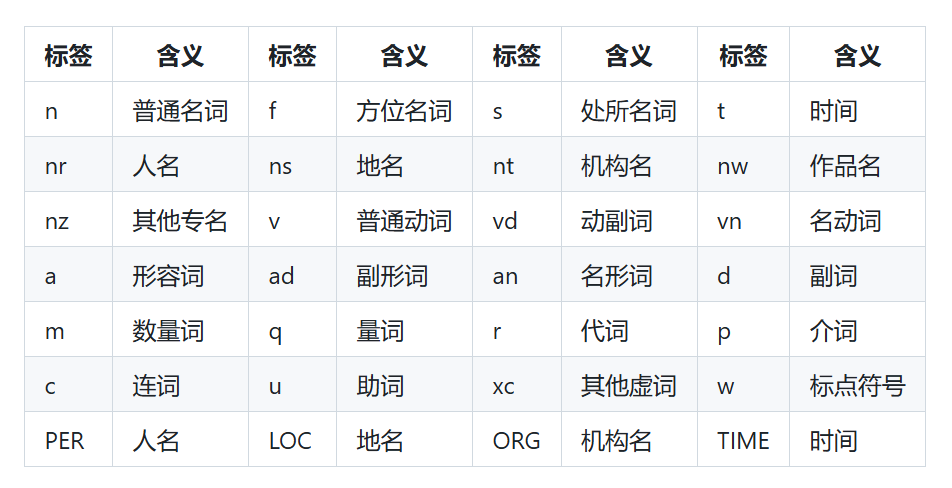

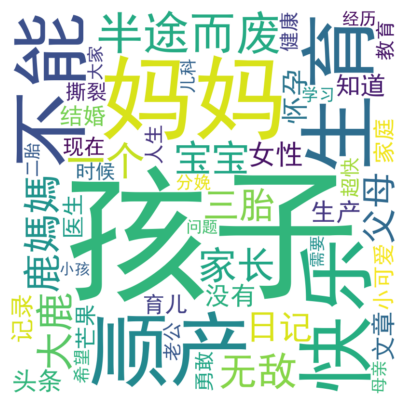

In [83]:
from wordcloud import WordCloud

# Generate a word cloud from the 'final_freq' dataframe
wordcloud = WordCloud(font_path='simhei.ttf', background_color='white', width=800, height=800)
wordcloud.generate_from_frequencies(dict(zip(final_freq['word'][:50], final_freq['count'][:50])))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# final_freq.to_csv(r"D:\weibo_result\keyword_freq.csv", index=False, encoding='utf-8-sig')

## 共现矩阵


In [ ]:
# 2021.1.1-5.30，2021.5.31-12.31，2022.1.1-2023.1.1，2023.1.1-2025.1.1

In [ ]:
word_freq = pd.read_csv(r"D:\weibo_result\计算结果\keyword_freq.csv")

In [20]:
keyword_list

[['孩子',
  '做错',
  '作业本',
  '老师',
  '自己',
  '讨厌',
  '抱怨',
  '舒服',
  '多久',
  '安慰',
  '忘记',
  '英语老师',
  '聊过',
  '吐槽',
  '惯着',
  '愿意',
  '狗血喷头',
  '烦死',
  '亲子关系',
  '面前'],
 ['胎儿',
  '37',
  '40',
  '脂肪',
  '出生',
  '发育',
  '38',
  '39',
  '功能',
  '为了',
  '分娩',
  '母体',
  '惧怕',
  '抗体',
  '体温',
  '储存',
  '大脑',
  '宝宝',
  '激素',
  '分泌'],
 ['生理期',
  '感同身受',
  '指望',
  '女性',
  '两大',
  '痛苦',
  '男人',
  '经历',
  '别人',
  '根本',
  '孩子',
  '所以',
  '知道'],
 ['超话', '微博', '纪元', '视频', '克服', '恐惧', '教育', '孩子', '如何', '管理', '时间'],
 ['一头',
  '孩子',
  '期望',
  '我们',
  '前行',
  '诱惑',
  '恐惧',
  '他们',
  '前进',
  '飞夺',
  '现代诗',
  '超话',
  '绶带',
  '泸定桥',
  '邻家',
  '光彩夺目',
  '释疑',
  '十步',
  '江流',
  '坠落'],
 ['土味',
  '反讽',
  '微博',
  '换位',
  '太好了',
  '偏见',
  '自古以来',
  '消退',
  '视频',
  '思考',
  '从未',
  '女性',
  '教授',
  '社会'],
 ['乖乖',
  '孕晚期',
  '第十一天',
  '论生个',
  '出鹅叫',
  '每天',
  '睡梦中',
  '天使',
  '失眠',
  '出声',
  '折腾',
  '安心',
  '哈哈',
  '宝宝',
  '可爱',
  '怀孕',
  '体重',
  '体验',
  '肚子',
  '什么'],
 ['生育力',
  '小编',
  '年龄',
  '疾病',
  '女性',
  '私信

In [ ]:
# cut_str_df = pd.DataFrame()
# start_from =40001
# for i, unit in tqdm(enumerate(cut_str_list[start_from:])):
#     if i == 0:
#         cut_str_df = pd.DataFrame(unit)
#         cut_str_df['weibo_idx'] = i+start_from
#     else:
#         tem = pd.DataFrame(unit)
#         tem['weibo_idx'] = i+start_from
#         cut_str_df = pd.concat([cut_str_df, tem], axis=0)
#     if (i+start_from) % 10000 == 0:
#         cut_str_df.to_csv(rf"D:\weibo_result\计算结果\cut_str_df_{i+start_from}.csv", index=False, encoding='utf-8-sig')

12204it [01:14, 163.62it/s]


In [ ]:
cut_str_df = pd.read_csv(r"D:\weibo_result\计算结果\cut_str_df_all.csv")
cut_str_df.rename(columns={'0': 'word'}, inplace=True)

In [ ]:
# selected_word_list = final_freq.iloc[:150]['word'].tolist()
# selected_word_list = pd.read_excel(r"D:\weibo_result\计算结果\高频词（前100）.xlsx", sheet_name='Sheet1')['word'].tolist()
selected_word_list = pd.read_csv(r"D:\weibo_result\计算结果\keyword_freq.csv").iloc[:100]['word'].tolist()

selected_word_df = cut_str_df[cut_str_df['word'].isin(selected_word_list)]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# 将 selected_word_df 按 weibo_idx 分组，并将每组的 word 列合并为一个字符串
grouped_texts = selected_word_df.groupby('weibo_idx')['word'].apply(lambda x: ' '.join(x)).tolist()

# 使用 CountVectorizer 构建词袋模型
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
X = vectorizer.fit_transform(grouped_texts)

# 计算共现矩阵
co_occurrence_matrix = (X.T @ X).toarray()

# 将共现矩阵转换为 DataFrame 以便查看
terms = vectorizer.get_feature_names_out()
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=terms, columns=terms)


c:\Users\Alber\anaconda3\envs\weibo\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
co_occurrence_df.to_csv(r"D:\weibo_result\计算结果\keyword_co_occurrence_df_top100.csv", index=True, encoding='utf-8-sig')